## Spage2vec Stereoseq

In [5]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt

In [6]:
from tqdm import tqdm
from scipy.spatial import cKDTree as KDTree

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

ModuleNotFoundError: No module named 'tensorflow'

In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [10]:
from stellargraph import * 

In [11]:
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.layer.graphsage import AttentionalAggregator
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar

ModuleNotFoundError: No module named 'stellargraph.data'

In [47]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from tensorflow.compat.v1.keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.random.set_seed(1234)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [48]:
from numpy.random import seed
seed(42)
#from tensorflow import set_random_seed
tf.random.set_seed(42)

In [12]:
barcodes_df = pd.read_csv("stereoseq.csv")
barcodes_df.columns = ['Gene', 'global_X_pos', 'global_Y_pos', "MIDCounts"]

In [17]:
barcodes_df

,Gene,global_X_pos,global_Y_pos,MIDCounts
0,0610005C13Rik,11271,7528,1
1,0610005C13Rik,9763,21366,1
2,0610005C13Rik,13474,13434,1
3,0610005C13Rik,15288,16152,1
4,0610005C13Rik,9727,9748,1
...,...,...,...,...
70013774,mt-Nd6,15156,11311,1
70013775,mt-Nd6,18046,10650,1
70013776,mt-Nd6,14677,19769,1
70013777,mt-Nd6,8884,8671,1


(5375.05, 20223.95, 5150.05, 24948.95)

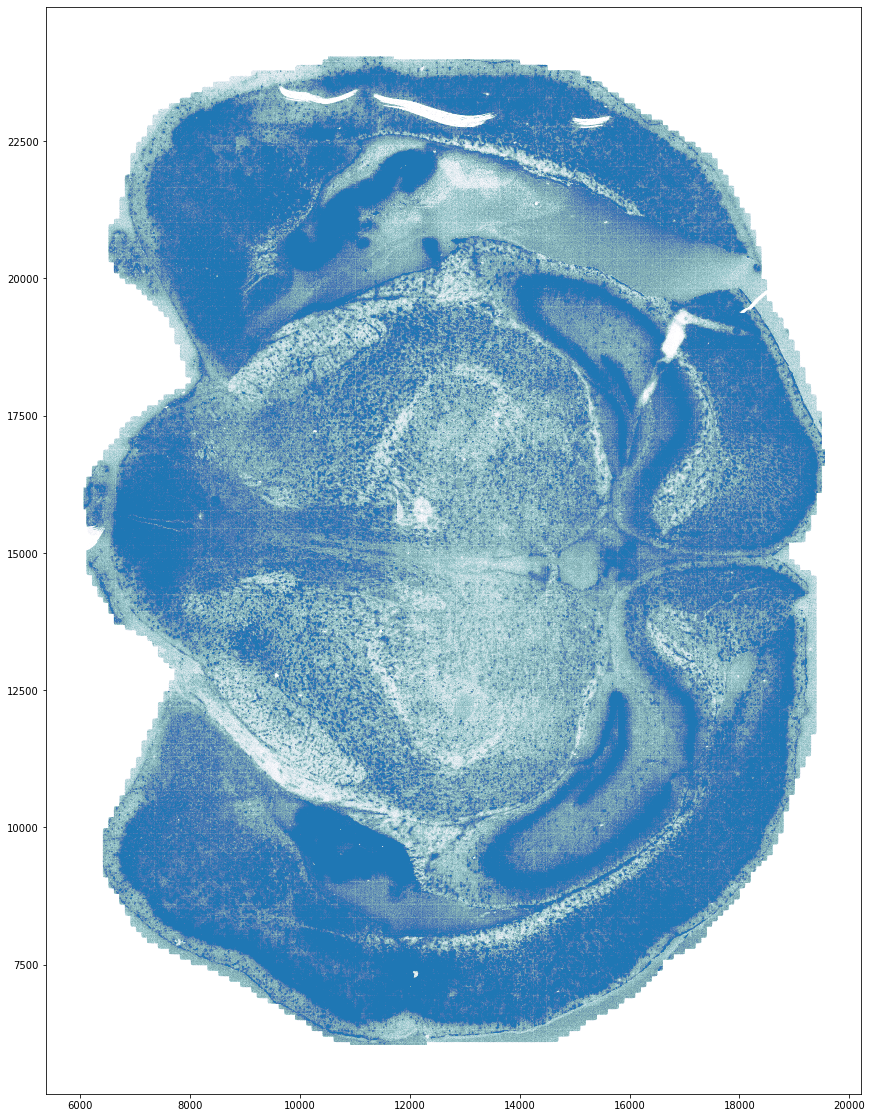

In [50]:
import matplotlib.pyplot as plt

X = barcodes_df.global_X_pos
Y = barcodes_df.global_Y_pos

plt.figure(figsize=(20,20))
plt.scatter(X,Y,s=0.00001)
plt.axis('scaled')

## 1. Getting a crop 

In [25]:
x_start = 12200 #12000
x_end = 13500 #14000
y_start=8200 #8000
y_end = 9500 #10000

In [26]:
sub_data = barcodes_df[(barcodes_df['global_X_pos'] > x_start) & 
                       (barcodes_df['global_X_pos'] < x_end) & 
                       (barcodes_df['global_Y_pos'] > y_start) & 
                       (barcodes_df['global_Y_pos'] < y_end)]

In [27]:
def rescale(data):
    new_data = data.assign(X = data['global_X_pos']-x_start, 
                Y = data['global_Y_pos']-y_start)
    return new_data

In [28]:
sub_data = rescale(sub_data)

In [29]:
sub_data

,Gene,global_X_pos,global_Y_pos,MIDCounts,X,Y
10,0610005C13Rik,12433,9328,1,233,1128
142,0610009B22Rik,12910,9228,1,710,1028
230,0610009B22Rik,13234,9274,1,1034,1074
471,0610009B22Rik,13498,9333,1,1298,1133
892,0610009B22Rik,12278,9145,1,78,945
...,...,...,...,...,...,...
70013123,mt-Nd6,12259,8443,1,59,243
70013305,mt-Nd6,13491,9100,1,1291,900
70013740,mt-Nd6,12203,8476,1,3,276
70013756,mt-Nd6,13284,8741,2,1084,541


(12136.1, 13563.9, 8136.1, 9563.9)

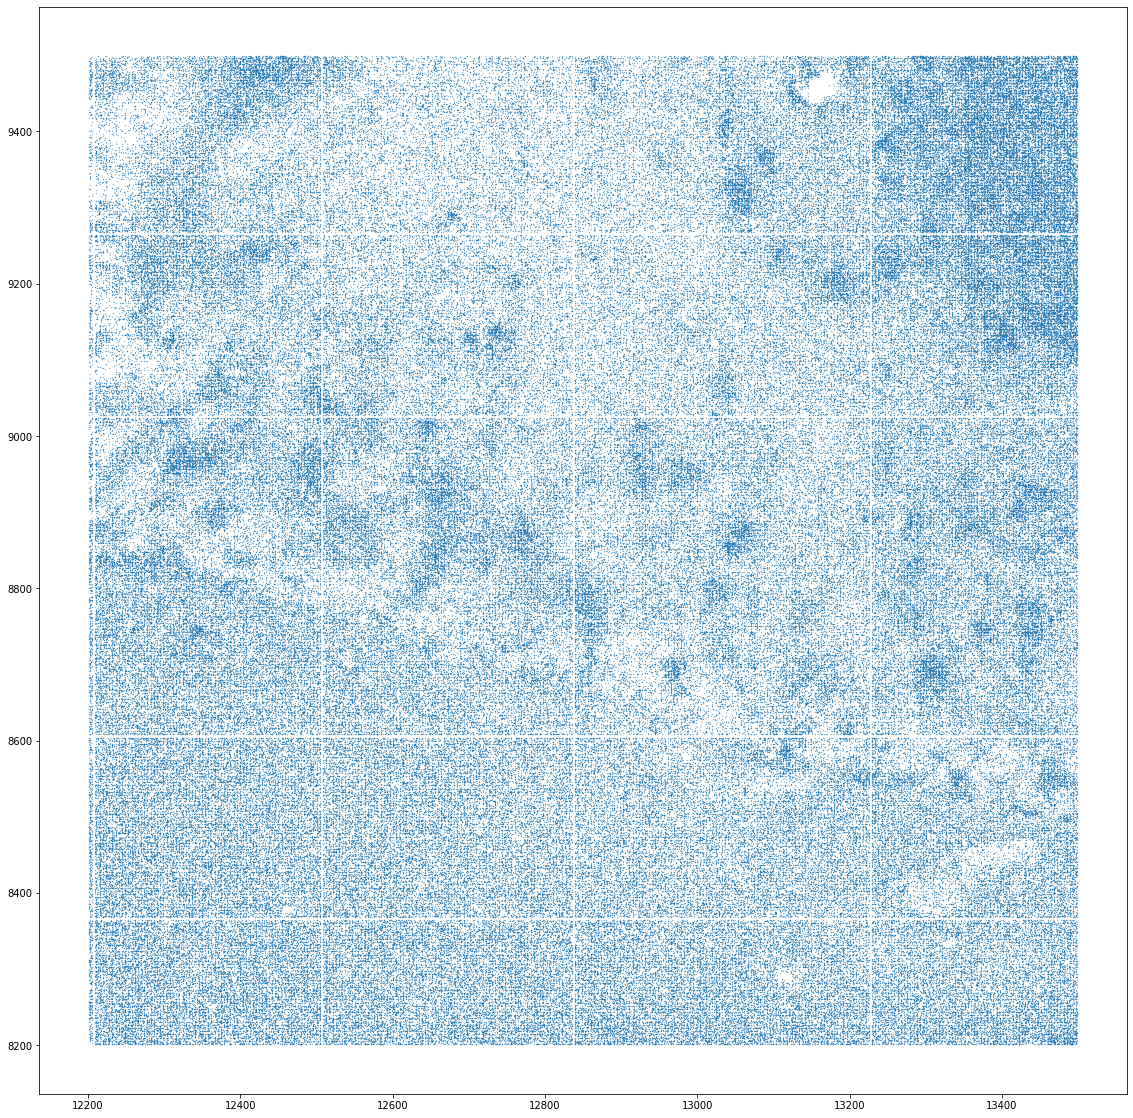

In [30]:
plt.figure(figsize=(20,20))
plt.scatter(sub_data.global_X_pos,sub_data.global_Y_pos,s=0.05)
plt.axis('scaled')

In [31]:
sub_data.to_csv("stereoseq_crop.csv", index = False)

In [32]:
barcodes_df = sub_data

## 2. Built spatial graph and GNN model

In [33]:
# Auxiliary function to compute d_max
def plotNeighbor(barcodes_df):
    barcodes_df.reset_index(drop=True, inplace=True)
    
    kdT = KDTree(np.array([barcodes_df.global_X_pos.values,barcodes_df.global_Y_pos.values]).T)
    d,i = kdT.query(np.array([barcodes_df.global_X_pos.values,barcodes_df.global_Y_pos.values]).T,k=2)
    plt.hist(d[:,1],bins=200);
    plt.axvline(x=np.percentile(d[:,1],97),c='r')
    print(np.percentile(d[:,1],97))
    d_th = np.percentile(d[:,1],97)
    return d_th

2.23606797749979


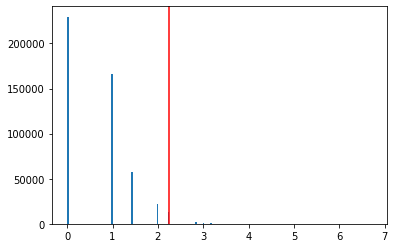

In [34]:
# Load gene panel taglist
tagList_df =pd.DataFrame(np.unique(barcodes_df["Gene"]), columns=['Gene'])

# Compute d_max for generating spatial graph
d_th = plotNeighbor(barcodes_df)

In [59]:
# Auxiliary function to build spatial gene expression graph
def buildGraph(barcodes_df, d_th, tagList_df):
    G = nx.Graph()
    features =[] 
    barcodes_df.reset_index(drop=True, inplace=True)
    
    gene_list = tagList_df.Gene.values
    # Generate node categorical features
    one_hot_encoding = dict(zip(gene_list,to_categorical(np.arange(gene_list.shape[0]),num_classes=gene_list.shape[0]).tolist()))
    barcodes_df["feature"] = barcodes_df['Gene'].map(one_hot_encoding).tolist()
    features.append(np.vstack(barcodes_df.feature.values))

    kdT = KDTree(np.array([barcodes_df.global_X_pos.values,barcodes_df.global_Y_pos.values]).T)
    res = kdT.query_pairs(d_th)
    res = [(x[0],x[1]) for x in list(res)]

    # Add nodes to graph
    G.add_nodes_from((barcodes_df.index.values), test=False, val=False, label=0)
    # Add node features to graph
    nx.set_node_attributes(G,dict(zip((barcodes_df.index.values), barcodes_df.feature)), 'feature')
    # Add edges to graph
    G.add_edges_from(res)

    return G, barcodes_df

In [60]:
# Build spatial gene expression graph
G, barcodes_df = buildGraph(barcodes_df, d_th, tagList_df)

In [69]:
# Store the graph
nx.write_gpickle(G, "stereo_seq_graph_crop.gpickle", protocol = 4)

In [14]:
# Load the spatial ge graph
G = nx.read_gpickle("stereo_seq_graph_crop.gpickle")

If I remove components then I can't proceed with the pipeline!

In [62]:
# Remove components with less than N nodes
N=3
for component in tqdm(list(nx.connected_components(G))):
    if len(component)<N:
        for node in component:
            G.remove_node(node)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103983/103983 [00:00<00:00, 480853.79it/s]


#### 1. Create the Stellargraph with node features.

In [68]:
G = sg.StellarGraph(G, node_features="feature")
print(G.info())

AttributeError: module 'stellargraph' has no attribute 'stellargraph'

#### 2. Specify the other optional parameter values: root nodes, the number of walks to take per node, the length of each walk, and random seed.

In [18]:
nodes = list(G.nodes())

In [20]:
len(nodes)

330522

In [19]:
number_of_walks = 1
length = 2

#### 3. Create the UnsupervisedSampler instance with the relevant parameters passed to it.

In [22]:
unsupervised_samples = UnsupervisedSampler(G, nodes=nodes, length=length, number_of_walks=number_of_walks, seed=42)

#### 4. Create a node pair generator:

In [23]:
batch_size = 50
epochs = 10
num_samples = [20, 10]

generator = GraphSAGELinkGenerator(G, batch_size, num_samples, seed=42)
train_gen = generator.flow(unsupervised_samples)

#### 5. Create neural network model

In [24]:
layer_sizes = [50, 50]
assert len(layer_sizes) == len(num_samples)

graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator = generator, 
    aggregator=AttentionalAggregator, bias=True, dropout=0.0, normalize="l2", kernel_regularizer='l1')

# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.build()

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method='ip')(x_out)

/var/folders/yw/dlmxgknn2xd3fkt37hvgf5r00000gn/T/ipykernel_14646/3346692201.py:9: DeprecationWarning: The 'build' method is deprecated, use 'in_out_tensors' instead.
  x_inp, x_out = graphsage.build()


link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [25]:
import os, datetime

logdir = os.path.join("logs", datetime.datetime.now().strftime("pciSeq-%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=1)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.5e-4),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20, 14851)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 200, 14851)  0           []                               
                                ]                                                                 
                                                                                                  
 input_5 (InputLayer)           [(None, 20, 14851)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 200, 14851)  0           []                           

#### 6. Train neural network model

In [74]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
tf.debugging.set_log_device_placement(True)

# Place tensors on the CPU
with tf.device('/CPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

# Run on the GPU
c = tf.matmul(a, b)
print(c)

In [71]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=True,
    workers=15,
    shuffle=True,
    callbacks=[tensorboard_callback,earlystop_callback])

2022-05-19 18:40:19.217108: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


23241/66105 [=========>....................] - ETA: 2:18:30 - loss: 1.5653 - binary_accuracy: 0.7272

## 3. Extract node embeddings

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stellargraph.mapper import GraphSAGENodeGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [31]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [32]:
# Save the model
embedding_model.save('models/stereo_seq/full_nn_model.h5')

In [14]:
# Recreate the exact same model purely from the file
embedding_model = keras.models.load_model('models/stereo_seq/full_nn_model.h5', custom_objects={'AttentionalAggregator':AttentionalAggregator})

In [34]:
embedding_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.5e-4),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy]
)

/Users/antonella/miniforge3/envs/segbench/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
nodes = list(G.nodes())
node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples, seed=42).flow(nodes)
node_embeddings = embedding_model.predict_generator(node_gen, workers=12, verbose=1)

NameError: name 'G' is not defined

In [36]:
np.save('stereoseq-embedding.npy',node_embeddings)

In [15]:
#node_embeddings = np.load('stereoseq-embedding.npy')

In [37]:
len(node_embeddings)

350068